# Machine Learning to Classify Insincere Quora Questions

**The aim is to be able to classify questions as sincere vs insincere using different features of the text and the question text itself. We will try Machine learning classification algorithms to solve the problem.**

In [1]:
import pandas as pd
import swifter
import numpy as np
import nltk
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from gensim.models import Word2Vec

In [2]:
data = pd.read_csv('final_processed_df.csv')

In [3]:
data.head()

,qid,question_text,target,length,capitals,caps_vs_length,num_words,num_unique_words,words_vs_unique,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,processed_text,len_after,num_words_after,len_ratio,num_words_ratio
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,72,2,0.027778,13,13,1.0000,0,1,0,0,quebec nationalist see province nation,38,5,1.894737,2.600000
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,81,1,0.012346,16,15,0.9375,0,1,1,0,adopt dog would encourage people adopt not shop,47,8,1.723404,2.000000
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,67,2,0.029851,10,8,0.8000,0,2,0,0,velocity affect time velocity affect space geo...,51,7,1.313725,1.428571
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,57,4,0.070175,9,9,1.0000,0,1,0,0,otto von guericke use magdeburg hemisphere,42,6,1.357143,1.500000
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,77,3,0.038961,15,15,1.0000,0,1,0,0,convert montra helicon mountain bike change tyre,48,7,1.604167,2.142857


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 18 columns):
qid                      1306122 non-null object
question_text            1306122 non-null object
target                   1306122 non-null int64
length                   1306122 non-null int64
capitals                 1306122 non-null int64
caps_vs_length           1306122 non-null float64
num_words                1306122 non-null int64
num_unique_words         1306122 non-null int64
words_vs_unique          1306122 non-null float64
num_exclamation_marks    1306122 non-null int64
num_question_marks       1306122 non-null int64
num_punctuation          1306122 non-null int64
num_symbols              1306122 non-null int64
processed_text           1305749 non-null object
len_after                1306122 non-null int64
num_words_after          1306122 non-null int64
len_ratio                1306122 non-null float64
num_words_ratio          1306122 non-null float64
dtypes: floa

In [5]:
def float_to_int(x):
    if x == float('inf') or x == float('-inf'):
        return float(0) # or a large value you choose
    return int(x)

data.len_ratio = data.len_ratio.swifter.apply(float_to_int)
data.num_words_ratio = data.num_words_ratio.swifter.apply(float_to_int)

data.processed_text = data.processed_text.fillna('')

In [6]:
data.describe()

,target,length,capitals,caps_vs_length,num_words,num_unique_words,words_vs_unique,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,len_after,num_words_after,len_ratio,num_words_ratio
count,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06
mean,6.187018e-02,7.067884e+01,2.860756e+00,4.557576e-02,1.280361e+01,1.213578e+01,9.666687e-01,1.742563e-03,1.057475e+00,2.904055e-01,1.543730e-02,4.271438e+01,6.453952e+00,1.206526e+00,1.660784e+00
std,2.409197e-01,3.878428e+01,2.573325e+00,3.919927e-02,7.052437e+00,6.040779e+00,5.687022e-02,4.676167e-02,2.588720e-01,7.637911e-01,1.502499e-01,2.517267e+01,3.730951e+00,5.222969e-01,6.736842e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,9.523810e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,4.500000e+01,1.000000e+00,2.000000e-02,8.000000e+00,8.000000e+00,9.354839e-01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.600000e+01,4.000000e+00,1.000000e+00,1.000000e+00
50%,0.000000e+00,6.000000e+01,2.000000e+00,3.389831e-02,1.100000e+01,1.100000e+01,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,3.600000e+01,5.000000e+00,1.000000e+00,2.000000e+00
75%,0.000000e+00,8.500000e+01,4.000000e+00,5.882353e-02,1.500000e+01,1.500000e+01,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,5.300000e+01,8.000000e+00,1.000000e+00,2.000000e+00
max,1.000000e+00,1.017000e+03,1.800000e+02,1.000000e+00,1.340000e+02,9.600000e+01,1.000000e+00,5.000000e+00,1.000000e+01,3.500000e+01,2.000000e+01,6.840000e+02,6.900000e+01,8.100000e+01,2.800000e+01


In [7]:
sincere_df = data[data['target']==0]
insincere_df = data[data['target']==1]

In [8]:
sincere_df_subset = sincere_df.sample(n=160000)

In [9]:
insincere_df = insincere_df.reset_index()
sincere_df_subset = sincere_df_subset.reset_index()

In [10]:
sincere_df_subset.shape

(160000, 19)

In [11]:
subset = pd.concat([sincere_df_subset, insincere_df],0)
subset = subset.drop(['index'],1)
subset.head()

,qid,question_text,target,length,capitals,caps_vs_length,num_words,num_unique_words,words_vs_unique,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,processed_text,len_after,num_words_after,len_ratio,num_words_ratio
0,eb18048e5b3be779eda4,Is there a benefit in allowing a 14 year old g...,0,104,1,0.009615,23,20,0.869565,0,1,0,0,benefit allow year old girl visit mom jail mon...,60,11,1.0,2.0
1,19c3cdb13292fdb5fca8,"If we all evolved from one living cell, where ...",0,77,1,0.012987,15,14,0.933333,0,1,1,0,evolve one live cell live cell come,35,7,2.0,2.0
2,25d36e47617b5732e03e,What is IC packing?,0,19,3,0.157895,4,4,1.000000,0,1,0,0,ic pack,7,2,2.0,2.0
3,41269501668c618e9fa3,How did Kalpit Veerwal prepare for NTSE?,0,40,7,0.175000,7,7,1.000000,0,1,0,0,kalpit veerwal prepare ntse,27,4,1.0,1.0
4,522520ade5686ec8e6b8,"In a power plant, what would be cause a huge w...",0,125,1,0.008000,24,22,0.916667,0,1,1,0,power plant would huge water leak gland seal t...,80,14,1.0,1.0


In [12]:
subset.shape

(240810, 18)

In [13]:
#split the data
X = subset.processed_text
y = subset.target


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((168567,), (168567,), (72243,), (72243,))

## Logistic Regression

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Text(0.5,1,'Confusion Matrix')

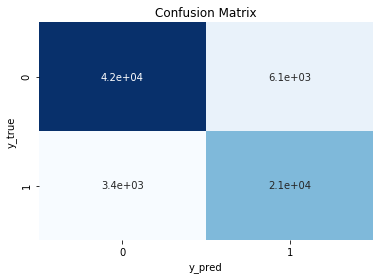

In [15]:
tf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1, 3))
lr = LogisticRegression()
pipeline_lr = Pipeline([('tfidf', tf_vec), ('lr', lr)])
pipeline_lr.fit(X_train, y_train)
y_pred = pipeline_lr.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

ax = plt.gca()
sns.heatmap(cm, cmap='Blues', cbar=False, annot=True, xticklabels=y_test.unique(), yticklabels=y_test.unique(), ax=ax)
ax.set_xlabel('y_pred')
ax.set_ylabel('y_true')
ax.set_title('Confusion Matrix')

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90     48081
           1       0.77      0.86      0.81     24162

   micro avg       0.87      0.87      0.87     72243
   macro avg       0.85      0.87      0.86     72243
weighted avg       0.87      0.87      0.87     72243



In [18]:
y_prob = pipeline_lr.predict_proba(X_test)
from sklearn.metrics import f1_score
best_threshold = 0
f1=0
for i in np.arange(.1, .51, 0.01):
    y_pred = [1 if proba>i else 0 for proba in y_prob[:, 1]]
    f1score = f1_score(y_pred, y_test)
    if f1score>f1:
        best_threshold = i
        f1=f1score
        
y_pred = [1 if proba>best_threshold else 0 for proba in y_prob[:, 1]]
f1 = f1_score(y_pred, y_test)
print('The best threshold is {}, with an F1 score of {}'.format(best_threshold, f1))

The best threshold is 0.48999999999999977, with an F1 score of 0.8150412836890482


### Count vectorizer SVD

In [19]:
count_vec = CountVectorizer(stop_words='english', ngram_range=(1, 3))
svd = TruncatedSVD(n_components=100, random_state=6)
tf_vec = TfidfVectorizer(stop_words='english')

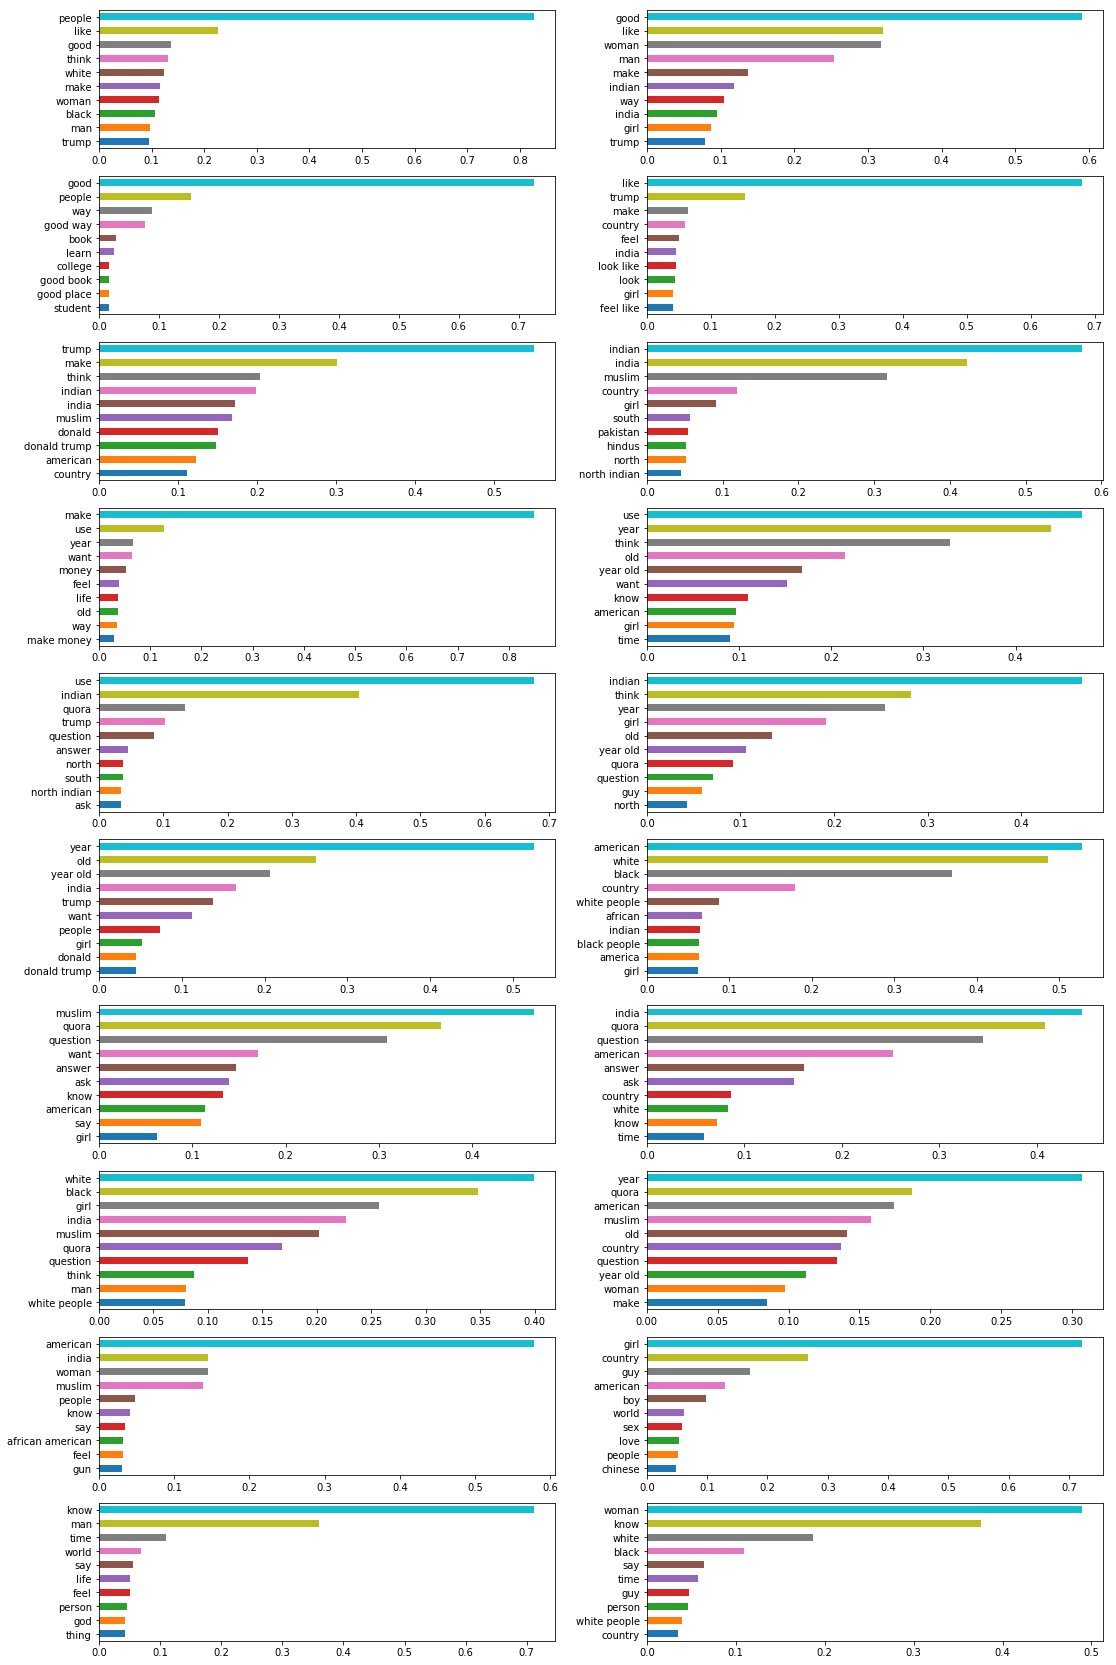

In [20]:
pipeline = Pipeline([('vectorizer', count_vec),('svd', svd)])
model = pipeline.fit_transform(X_train)

components = pd.DataFrame(data=svd.components_, columns=pipeline.named_steps['vectorizer'].get_feature_names())

fig, axes = plt.subplots(10, 2, figsize=(18, 30))
for i, ax in enumerate(axes.flat):
    components.iloc[i].sort_values(ascending=False)[:10].sort_values().plot.barh(ax=ax)
    

## Naive Bayes

In [21]:
mb = MultinomialNB()
pipeline_mb = Pipeline([ ('vectorizer', tf_vec), ('mb', mb)])

pipeline_mb.fit(X_train, y_train)
y_pred = pipeline_mb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
labels = ['sincere', 'insincere']
df_cm = pd.DataFrame(cm, columns=labels, index=labels)
df_cm

,sincere,insincere
sincere,43486,4595
insincere,5667,18495


In [22]:
score = cross_val_score(pipeline_mb, X_test, y=y_test, cv=3, scoring='f1_macro')
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89     48081
           1       0.80      0.77      0.78     24162

   micro avg       0.86      0.86      0.86     72243
   macro avg       0.84      0.83      0.84     72243
weighted avg       0.86      0.86      0.86     72243



## KNN

In [23]:
knn = KNeighborsClassifier()
pipeline_knn = Pipeline([ ('vectorizer', tf_vec), ('mb', knn)])

pipeline_knn.fit(X_train, y_train)
y_pred = pipeline_knn.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
labels = ['sincere', 'insincere']
df_cm = pd.DataFrame(cm, columns=labels, index=labels)
df_cm

,sincere,insincere
sincere,46325,1756
insincere,18195,5967


In [24]:
score = cross_val_score(pipeline_mb, X_test, y=y_test, cv=3, scoring='f1_macro')
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.96      0.82     48081
           1       0.77      0.25      0.37     24162

   micro avg       0.72      0.72      0.72     72243
   macro avg       0.75      0.61      0.60     72243
weighted avg       0.74      0.72      0.67     72243



## XGb

In [25]:
xgbc = xgb.XGBClassifier() 
pipeline_xgb = Pipeline([ ('vectorizer', tf_vec), ('mb', xgbc)])

pipeline_xgb.fit(X_train, y_train)
y_pred = pipeline_xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
labels = ['sincere', 'insincere']
df_cm = pd.DataFrame(cm, columns=labels, index=labels)
df_cm

,sincere,insincere
sincere,45808,2273
insincere,12290,11872


In [26]:
score = cross_val_score(pipeline_xgb, X_test, y=y_test, cv=3, scoring='f1_macro')
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.95      0.86     48081
           1       0.84      0.49      0.62     24162

   micro avg       0.80      0.80      0.80     72243
   macro avg       0.81      0.72      0.74     72243
weighted avg       0.81      0.80      0.78     72243



## Word2Vec

In [27]:
def text_preprocess(text):
    text = text.lower() 
    text = re.sub('[^a-zA-Z]', ' ', text) 
    text = re.sub(r'\s+', ' ', text)
    return text

q_text = subset.question_text.swifter.apply(text_preprocess)

Pandas Apply: 100%|██████████| 240810/240810 [00:03<00:00, 64051.65it/s]


In [28]:
all_words = [nltk.word_tokenize(sent) for sent in q_text]

In [29]:
word2vec = Word2Vec(all_words, min_count=2)  
vocabulary = word2vec.wv.vocab

In [30]:
word2vec.wv.most_similar('toxic')

[('shyness', 0.7524860501289368),
 ('fatigue', 0.7450121641159058),
 ('pastors', 0.7355822920799255),
 ('predatory', 0.7350690364837646),
 ('materialistic', 0.7335448265075684),
 ('conscious', 0.7329297661781311),
 ('feminazi', 0.7237725257873535),
 ('manipulative', 0.7236486077308655),
 ('rh', 0.7224127054214478),
 ('insensitive', 0.7193822264671326)]

In [31]:
word2vec.wv.most_similar('insincere')

[('anonymously', 0.8535091876983643),
 ('silly', 0.8405277132987976),
 ('asinine', 0.8275602459907532),
 ('upvote', 0.8202505111694336),
 ('spamming', 0.8188164234161377),
 ('anonymous', 0.8159993290901184),
 ('rhetorical', 0.8130093216896057),
 ('idiotic', 0.8070125579833984),
 ('trollish', 0.8046947717666626),
 ('loaded', 0.8026214838027954)]

In [32]:
word2vec.wv.most_similar('racist')

[('sexist', 0.7015141248703003),
 ('conservative', 0.6914782524108887),
 ('racism', 0.685300350189209),
 ('offensive', 0.6836000680923462),
 ('selfish', 0.6727032661437988),
 ('bigoted', 0.667858362197876),
 ('liberal', 0.6600009799003601),
 ('racists', 0.6589841842651367),
 ('nationalist', 0.6513960361480713),
 ('christian', 0.6245042085647583)]

## Logistic regression with all variables

In [22]:
subset_dropcols = subset.drop(['qid','question_text','target', 'processed_text'],1)

In [23]:
ngram = CountVectorizer(ngram_range=(3,3), max_df=0.50, min_df= 20)
ngram_matrix = ngram.fit_transform(subset.processed_text)

ngram_matrix = ngram_matrix.toarray()
vocab = ngram.get_feature_names()
ngram_df = pd.DataFrame(ngram_matrix, columns=vocab)

In [24]:
ngram_df=ngram_df.reset_index()
subset_dropcols =subset_dropcols.reset_index()
subset_ngram = pd.concat([subset_dropcols, ngram_df], 1)

In [25]:
subset_ngram = subset_ngram.drop(['index'],1)
subset_ngram.head()

,length,capitals,caps_vs_length,num_words,num_unique_words,words_vs_unique,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,...,would win fight,write style structure,year old boy,year old daughter,year old girl,year old guy,year old man,year old son,year old woman,yearold girl bore
0,104,1,0.009615,23,20,0.869565,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,77,1,0.012987,15,14,0.933333,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,19,3,0.157895,4,4,1.000000,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,40,7,0.175000,7,7,1.000000,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,125,1,0.008000,24,22,0.916667,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
X = subset_ngram
y = subset.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Text(0.5,1,'Confusion Matrix')

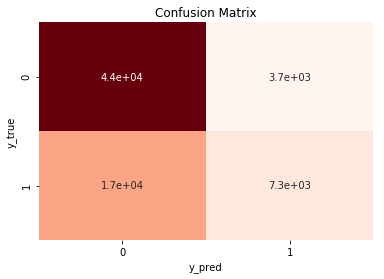

In [41]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

ax = plt.gca()
sns.heatmap(cm, cmap='Reds', cbar=False, annot=True, xticklabels=y_test.unique(), yticklabels=y_test.unique(), ax=ax)
ax.set_xlabel('y_pred')
ax.set_ylabel('y_true')
ax.set_title('Confusion Matrix')

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.92      0.81     48081
           1       0.66      0.30      0.42     24162

   micro avg       0.72      0.72      0.72     72243
   macro avg       0.69      0.61      0.61     72243
weighted avg       0.70      0.72      0.68     72243



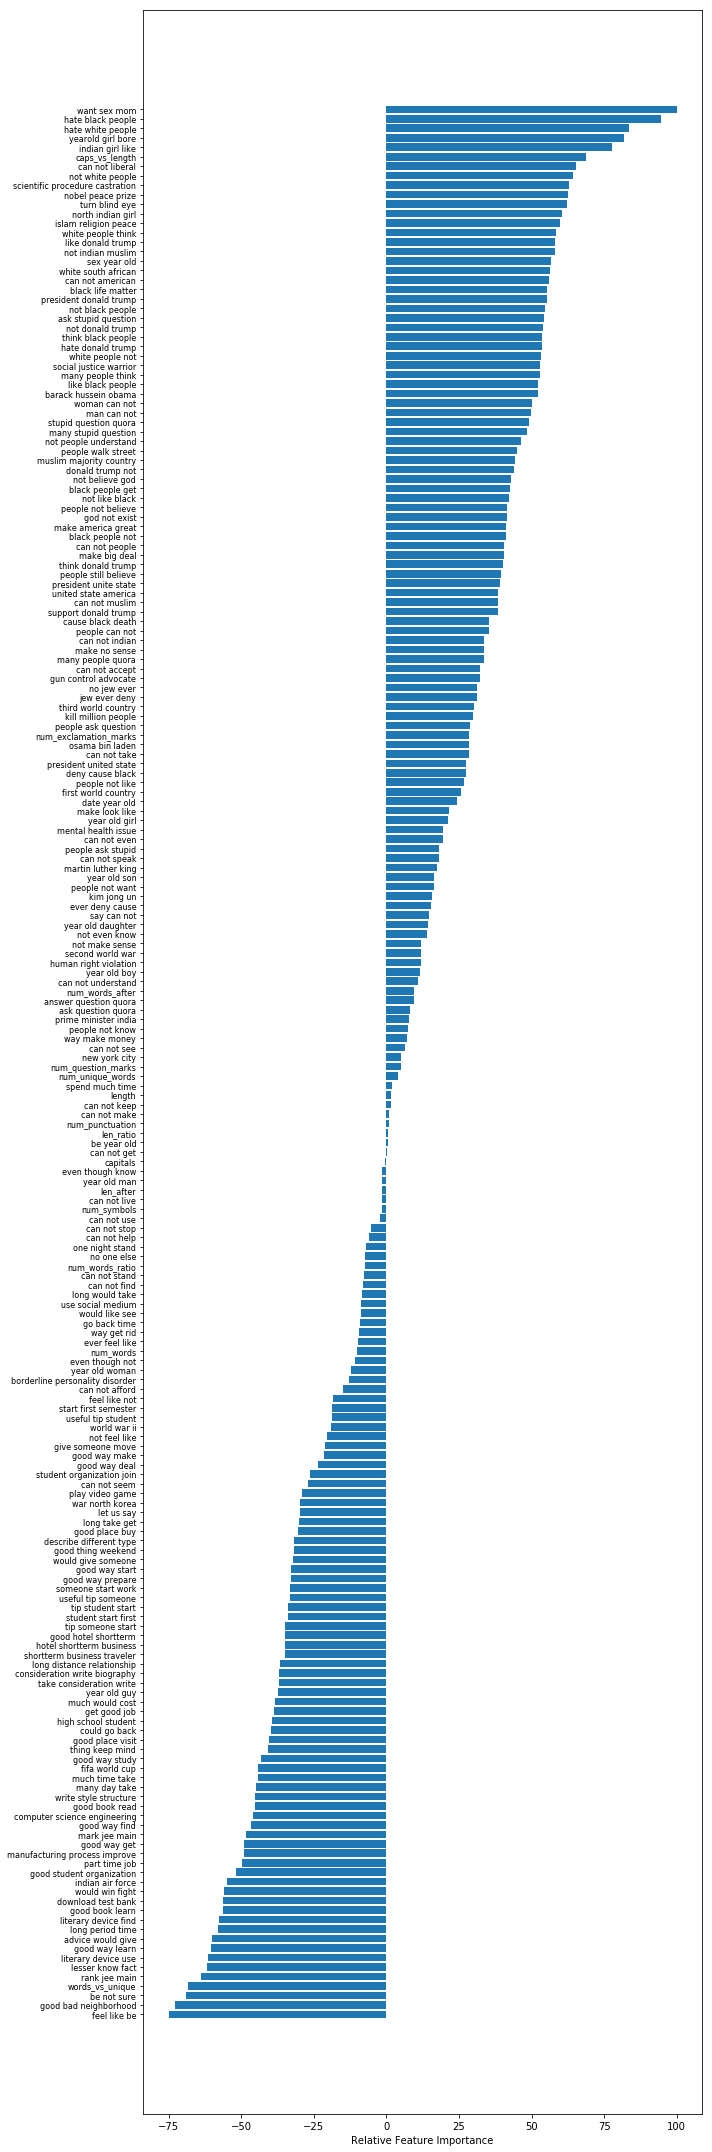

In [40]:
feature_importance = (lr.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(10,30))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()